In [1]:
#data format library
import h5py

#numpy
import numpy as np
import pandas as pd
import numpy.ma as ma
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams["font.family"] = "Times New Roman"
# %matplotlib notebook
import sys
sys.path.append('/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/')
import matplotlib.colors as pltcolors
import os
import copy
import glob
import clustering_methods as cl
import operator_calculations as op_calc
import delay_embedding as embed
import stats
from sklearn.decomposition import PCA
import time
import scipy

np.random.seed(42)

import importlib
importlib.reload(stats)

<module 'stats' from '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/stats.py'>

In [2]:
path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/Ph_Data/'
# f = h5py.File(path_to_filtered_data+'filtered_data.h5','r')
f = h5py.File(path_to_filtered_data+'filtered_phdata9_condition_3.h5','r')
# f = h5py.File(path_to_filtered_data+'filtered_phdata_condition_1.h5','r')
# f = h5py.File(path_to_filtered_data+'filtered_phdata_condition_2.h5','r')
# print(list(f.keys()))
# print(list(f['MetaData'].keys()))
lengths = np.array(f['MetaData/lengths_data'],dtype=int)
bout_dur_for_pca = np.array(f['MetaData/bout_duration_for_pca'],dtype=int)[0] #bout duration
frameRate = np.array(f['MetaData/frameRate'])[0] #sampling frame rate
ph_idx = np.array(f['MetaData/ph_idx'])
#min_bouts = np.array(f['MetaData/min_bouts'],dtype=int)[0] #mininum number of bouts per fish
# bouttypes = ma.array(f['MetaData/bout_types'])
# motifs = ma.array(f['MetaData/motifs'])
t0_bout = np.array(f['MetaData/t0_bout'],dtype=int)[0] #initial time bout
time_Bout = ma.array(f['times_bouts']) #raw times bouts
#shapes are n_fish, max_n_bouts,dim of variable
X_head = ma.array(f['head_pos'])
phi_raw = ma.array(f['orientation_raw'])
phi_smooth = ma.array(f['orientation_smooth'])
pca_fish = ma.array(f['pca_fish'])
pca_raw_fish = ma.array(f['pca_raw_fish'])
speeds_head = ma.array(f['speed_head'])
tail_angles_raw = ma.array(f['tail_angle_raw'])
tail_angles_smooth = ma.array(f['tail_angle_smooth'])
tail_angles_speed = ma.array(f['tail_angle_speed'])
thetas_aligned = ma.array(f['tail_angles_aligned'])
thetas_raw = ma.array(f['tail_angles_raw'])
skeletons = ma.array(f['tail_points_xy'])
f.close()

In [3]:
print(time_Bout.shape)
print(phi_smooth.shape)
print(speeds_head.shape)

(218, 946, 2)
(218, 946, 40)
(218, 946, 40)


In [4]:
## Load symbolic sequences

path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Results/'
f = h5py.File(path_to_filtered_data + 'filtered_phdata9_condition_3/kmeans_labels_K7_N1100.h5')
lengths_all = np.array(f['MetaData/lengths_data'], dtype=int)
labels_fish = ma.array(f['labels_fish'],dtype=int)
state_trajs = ma.array(f['state_trajs'])
f.close()

In [5]:
to_mask = 1200

maxL = np.max(lengths_all)

labels_fish[labels_fish == to_mask] = ma.masked

In [6]:
## Select Dataset
np.random.seed(42)
seeds = np.random.randint(0,10000,20)
delay_range = np.arange(1,20,1)
dt = 1
div= 218
n_modes=10
labels_all= ma.concatenate(labels_fish,axis=0)
print(labels_fish.shape)

(218, 946)


In [8]:
def sampler(labels_fish, ph_idx ,lengths_all, window_size, to_mask, s):
    np.random.seed(s)
#     condition_recs = np.array([[0,281],[281,584]])
    sampled_labels = []
    for cond in range(2):
        cond_recs = np.where(ph_idx == cond)[0]
        samples_ = to_mask*ma.ones((window_size+4,), dtype=int)
        labels_cond = labels_fish[cond_recs]
        rec_list = []
        for i, l in enumerate(lengths_all[cond_recs]):
            labels_cond[i,l-2:l] = ma.masked
            rec_list.append(labels_cond[i,:l])
        
        labels_ = ma.hstack(rec_list)
        start_pos = np.random.randint(0, len(labels_)-window_size)
        
        samples_[2:-2] = labels_[start_pos:start_pos+window_size]
        samples_[samples_==to_mask] = ma.masked
        sampled_labels.append(samples_)
    return sampled_labels

## Compute implied time scales

In [12]:
## Calculate by sampling similar number of bouts from each condition

ts_traj_delay = ma.zeros((seeds.shape[0],len(delay_range),n_modes))
eigvals_shuffle = ma.zeros((seeds.shape[0],n_modes))

window_size = 40000

for i,s in enumerate(seeds):
    print(s)
    labels_bootstrap = sampler(labels_fish, ph_idx,lengths_all, window_size, to_mask, s)
    labels_ = ma.hstack(labels_bootstrap)
    nstates = ma.max(labels_) + 1
    segments = op_calc.segment_maskedArray(labels_)

    dtrajs = np.asarray([labels_[t0:tf] for t0,tf in segments])
    if ma.count(labels_)>20:
        for kd,delay in enumerate(delay_range):
            ts_traj_delay[i,kd,:] = op_calc.implied_tscale_shuffle(dtrajs,nstates,delay,dt,n_modes,reversible=True)

#     labels_shuffle = labels_[np.random.choice(np.arange(len(labels_)),len(labels_))]
#     P_shuffle = op_calc.transition_matrix(labels_shuffle,1)
    P_shuffle = op_calc.transition_matrix_shuffle(dtrajs,1)
    R_shuffle = op_calc.get_reversible_transition_matrix(P_shuffle)
    eigvals,eigvecs = op_calc.sorted_spectrum(R_shuffle,k=n_modes+1)
    sorted_indices = np.argsort(eigvals.real)[::-1]
    eigvals = eigvals[sorted_indices][1:].real
    eigvals[np.abs(eigvals-1)<1e-12] = np.nan
    eigvals[eigvals<1e-12] = np.nan
    eigvals_shuffle[i,:] = eigvals

7270


/Users/gautam.sridhar/zilo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


860
5390
5191
5734
6265
466
4426
5578
8322
1685
769
6949
2433
5311
5051
6420
1184
4555
3385


In [17]:
ts_traj_delay[ts_traj_delay==0] = ma.masked
eigvals_shuffle[eigvals_shuffle == 0] = ma.masked 

## Use if sampling similar number of bouts from each condition

ts_traj_delay_total = ts_traj_delay
eigvals_shuffle_total = eigvals_shuffle

In [18]:
print(ts_traj_delay_total.shape)
print(eigvals_shuffle_total.shape)

(20, 19, 10)
(20, 10)


In [19]:
print(delay_range)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


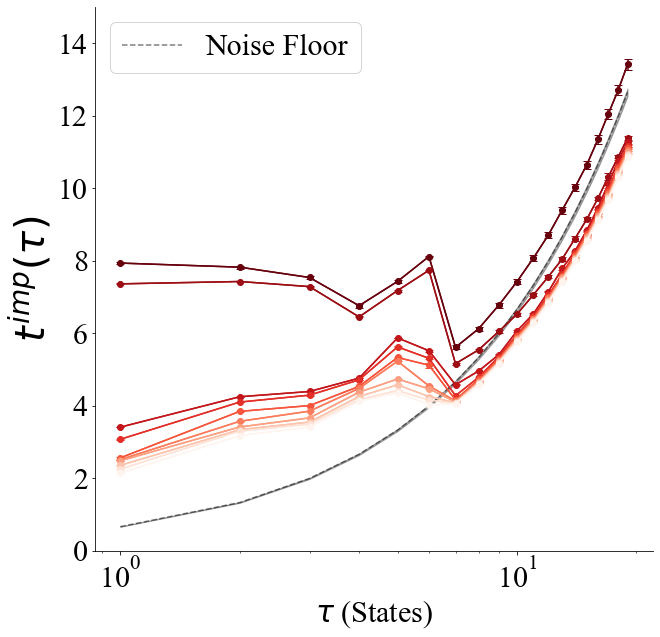

In [21]:
# time scales
colors_ = plt.cm.Reds_r(np.linspace(0,1,n_modes))

fig, ax = plt.subplots(1,1,figsize=(10,10))
for mode in range(n_modes):
    mean = ma.mean(ts_traj_delay_total[:,:,mode],axis=0)
    mean,cil,ciu=stats.bootstrap(ts_traj_delay_total[:,:,mode].squeeze(),median=False,n_times=1000)
    ax.plot(delay_range*dt,mean,c=colors_[mode], marker='*')
    ax.errorbar(delay_range*dt, mean,[mean-cil, ciu - mean], marker='o', capsize=4, color = colors_[mode])
tscales_shuffle = np.array([-d/np.log(eigvals_shuffle_total[:,0]) for d in delay_range])
mean,cil,ciu = stats.bootstrap(tscales_shuffle.T,n_times=100)

ax.plot(delay_range*dt,mean,c='k',alpha=.5,ls='--', label='Noise Floor')
ax.fill_between(delay_range*dt,cil,ciu,color='k',alpha=.3)
ax.legend(fontsize = 30)
ax.set_xlabel(r'$\tau$ (States)',fontsize=30)
ax.set_ylabel(r'$t^{imp} (\tau)$',fontsize=40)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xscale('log')

ax.set_ylim(0,15)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl6/implied_timescales.pdf')
plt.show()

(array([1., 2., 3., 4., 5., 6., 7., 8.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

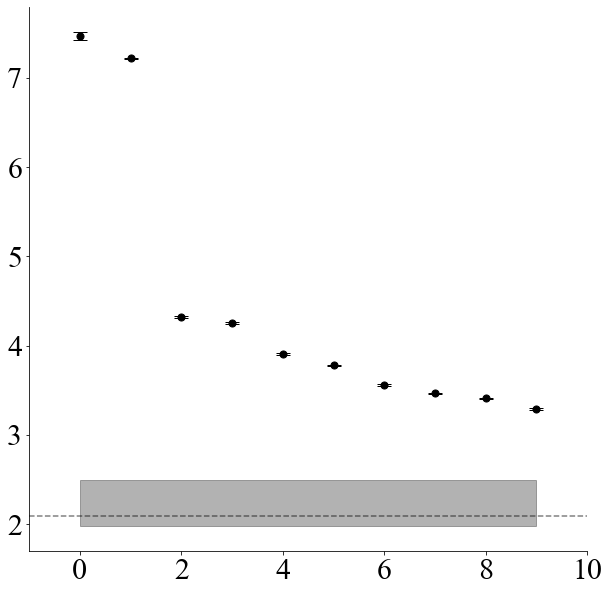

In [11]:
colors_ = plt.cm.Reds_r(np.linspace(0,1,n_modes))

fig, ax = plt.subplots(1,1,figsize=(10,10))

tau = 3

ts_traj_delay1 = ts_traj_delay_total[:,tau-1,:]

# for mode in range(n_modes):
mean,cil,ciu=stats.bootstrap(ts_traj_delay1[:,:],median=False,n_times=1000)
ax.scatter(np.arange(n_modes),mean,c='k', s =50)
ax.errorbar(np.arange(n_modes), mean,[mean-cil, ciu - mean], fmt='.', capsize=7, elinewidth=3, color = 'k')

mean = tscales_shuffle.mean(axis=1)
cil = np.percentile(tscales_shuffle,2.5,axis=1)
ciu = np.percentile(tscales_shuffle,97.5,axis=1)
ax.axhline(mean[tau-1],c='k',alpha=.5,ls='--', label='Noise Floor')
ax.fill_between(np.arange(n_modes),cil[tau-1]*np.ones(n_modes),ciu[tau-1]*np.ones(n_modes),color='k',alpha=.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlim(-1,10)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig2/implied_timescales_t3_jm_forward.pdf')

In [9]:
# Sample equal number of bouts from each condition to find coherence based partition point

np.random.seed(42)
seeds = np.random.randint(0,10000,100)
window_size = 40000
delay = 3
dt = 1
print(delay)

Ps = np.zeros((len(seeds),1100,1100))

phi2s = []
eigs = []
c_ranges = []
rhos = []
ms = []
splits = []
rec_idxs = []

for cf,s in enumerate(seeds):
    print(s)
    labels_bootstrap = sampler(labels_fish, ph_idx,lengths_all, window_size,to_mask,s)
    print(np.unique(labels_bootstrap).shape)
    labels_ = ma.hstack(labels_bootstrap)
    lcs,P = op_calc.transition_matrix(labels_,delay,return_connected=True)
    for i,l in enumerate(lcs):
        Ps[cf, l,lcs] = P.todense()[i]

P_avg = Ps.mean(axis=0)
row_sums = P_avg.sum(axis=1)
P_ensemble = P_avg / row_sums[:, np.newaxis]

3
7270
(1101,)
860
(1101,)
5390
(1101,)
5191
(1101,)
5734
(1101,)
6265
(1101,)
466
(1101,)
4426
(1101,)
5578
(1101,)
8322
(1101,)
1685
(1101,)
769
(1101,)
6949
(1101,)
2433
(1101,)
5311
(1101,)
5051
(1101,)
6420
(1101,)
1184
(1101,)
4555
(1101,)
3385
(1101,)
6396
(1101,)
8666
(1101,)
9274
(1101,)
2558
(1101,)
7849
(1101,)
2047
(1101,)
2747
(1101,)
9167
(1101,)
9998
(1101,)
189
(1101,)
2734
(1101,)
3005
(1101,)
4658
(1101,)
1899
(1101,)
7734
(1101,)
1267
(1101,)
1528
(1101,)
3556
(1101,)
3890
(1101,)
8838
(1101,)
5393
(1101,)
8792
(1101,)
8433
(1101,)
7513
(1101,)
2612
(1101,)
7041
(1101,)
9555
(1101,)
6235
(1101,)
5486
(1101,)
7099
(1101,)
9670
(1101,)
775
(1101,)
8226
(1101,)
3152
(1101,)
1585
(1101,)
3943
(1101,)
7555
(1101,)
3073
(1101,)
1021
(1101,)
3843
(1101,)
7989
(1101,)
9692
(1101,)
6873
(1101,)
5675
(1101,)
161
(1101,)
4297
(1101,)
995
(1101,)
7629
(1101,)
9467
(1101,)
1016
(1101,)
7869
(1101,)
6439
(1101,)
7892
(1101,)
6863
(1101,)
7916
(1101,)
8529
(1101,)
878
(1101,)
9268


In [10]:
from scipy.sparse import diags,identity,coo_matrix, csr_matrix
P_ensemble = csr_matrix(P_ensemble)

In [11]:
# Perform coherence based split on whole dataset
# np.random.seed(25)
import msmtools.estimation as msm_estimation
delay = 3
dt = 1
print(delay)
# lcs_ensemble,P_full = op_calc.transition_matrix(labels_all,delay,return_connected=True)
lcs_ensemble = msm_estimation.largest_connected_set(P_ensemble)
inv_measure = op_calc.stationary_distribution(P_ensemble)
final_labels = op_calc.get_connected_labels(labels_all,lcs_ensemble)
R = op_calc.get_reversible_transition_matrix(P_ensemble)
eigvals,eigvecs = op_calc.sorted_spectrum(R,k=10,seed=43)
sorted_indices = np.argsort(eigvals.real)[::-1]
eigvals = eigvals[sorted_indices][1:].real
eigvals[np.abs(eigvals-1)<1e-12] = np.nan
eigvals[eigvals<1e-12] = np.nan
t_imp =  -(delay*dt)/np.log(np.abs(eigvals))
eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
eigfunctions_traj[final_labels.mask] = ma.masked

phi1 = eigfunctions[:,1]
phi2 = eigfunctions[:,2]
phi3 = eigfunctions[:,3]
c_range_phi1,rho_sets,measures,split_idx_phi1,coh_labels_phi1 = op_calc.optimal_partition(phi1,inv_measure,P_ensemble,return_rho=True)

print(c_range_phi1[split_idx_phi1])

3
-0.011053021178487218


In [12]:
eigvals,eigvecs = op_calc.sorted_spectrum(P_ensemble,k=10,seed=43)
eigvals = eigvals[sorted_indices][1:].real
eigvals[np.abs(eigvals-1)<1e-12] = np.nan
eigvals[eigvals<1e-12] = np.nan
t_imp =  -(delay*dt)/np.log(np.abs(eigvals))

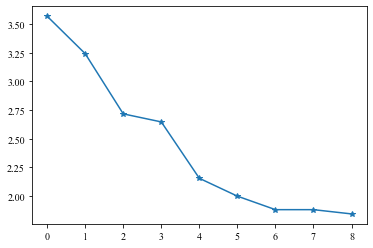

In [13]:
# Visualize implied timescales on whole operator
plt.plot(t_imp, marker='*')

In [14]:
print(rho_sets.shape)

(1098, 2)


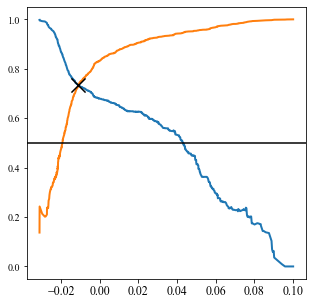

In [15]:
plt.figure(figsize=(5,5))
for i in range(2):
    plt.plot(c_range_phi1,rho_sets[:,i],lw=2)
rho_c = np.min(rho_sets,axis=1)
plt.scatter(c_range_phi1[split_idx_phi1],rho_c[split_idx_phi1],c='k',marker='x',s=200, zorder=30)
# plt.axvline(-0.015)
# plt.axvline(0.001)
# plt.plot(c_range_phi2,rho_c,c='k',marker='*', alpha =.5)
# plt.ylim(.7,0.9)
# plt.xlim(-0.02,0.015)

# plt.xlabel(r'$\phi_2$',fontsize=15)
# plt.ylabel(r'$\rho$',fontsize=15)
plt.axhline(0.5, c='k')
plt.xticks(fontsize=12)
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl2/coherence.pdf')
plt.show()

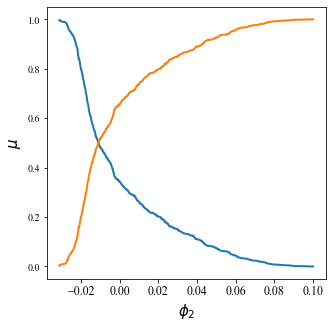

In [16]:
# Plot measure preserved in each metastate

plt.figure(figsize=(5,5))
plt.plot(c_range_phi1,measures,lw=2)
rho_c = np.min(measures,axis=1)
# plt.scatter(c_range[split_idx],measures[split_idx],c='r',marker='x',s=100)
# plt.plot(c_range,measures,c='k',marker='*', alpha =.5)
# plt.ylim(.5,0.9)
# plt.xlim(-0.02,0.005)

plt.xlabel(r'$\phi_2$',fontsize=15)
plt.ylabel(r'$\mu$',fontsize=15)
plt.xticks(fontsize=12)
# plt.savefig('Results/Condition1/state_partition.png')
plt.show()

In [17]:
split_locs = []
distorted_eigfs = np.zeros((eigfunctions.shape[0], eigfunctions.shape[1]-1))
for i in range(1,eigfunctions.shape[1]):
    phi = eigfunctions[:,i]
    _,_,_,split_idx,_ = op_calc.optimal_partition(phi,inv_measure,P_ensemble,return_rho=True)

    sort_range = np.sort(phi)
    neg_range = np.linspace(-1,0, len(sort_range[0:split_idx]))
    pos_range = np.linspace(0,1,len(sort_range[split_idx:]))
    distort_r = np.hstack([neg_range,pos_range])
    distort = np.zeros(phi.shape)

    pos = [np.where(phi == a)[0][0] for a in np.sort(phi)]

    for j in range(phi.shape[0]):
        distort[pos[j]] = distort_r[j]

    distorted_eigfs[:,i-1] = distort
    split_locs.append(split_idx)

In [27]:
distort_traj = ma.array(distorted_eigfs[:,0])[final_labels]
distort_traj[final_labels.mask] = ma.masked
dtrajs_fish_phi1 = distort_traj.reshape(labels_fish.shape[0],labels_fish.shape[1])

distort_traj = ma.array(distorted_eigfs[:,1])[final_labels]
distort_traj[final_labels.mask] = ma.masked
dtrajs_fish_phi2 = distort_traj.reshape(labels_fish.shape[0],labels_fish.shape[1])

In [53]:
# Kinematics calculation

phi_smooth[phi_smooth == 0] = ma.masked
phi_smooth = phi_smooth[:,:maxL,:]

In [54]:
phis_all = ma.concatenate(phi_smooth,axis=0)
delphi = (ma.abs(phis_all[1:,0] - phis_all[:-1,0]))*(180/np.pi)
psi = ma.zeros(phis_all.shape[0])
psi[:-1] = delphi
psi[-1] = ma.masked

In [55]:
psi = psi.reshape(phi_smooth.shape[0],phi_smooth.shape[1])
print(psi.shape)

(218, 946)


In [141]:
K=7
meanKphi_fish = [ma.abs(psi[:,k:k+K]).mean(axis=1) for k in range(len(psi[0])-K)]
meanKphi_fish = ma.vstack(meanKphi_fish).T

meanKphi = -1*ma.ones((psi.shape[0],psi.shape[1]))
meanKphi[:,3:-4] = meanKphi_fish
print(meanKphi.shape)

meanKphi[meanKphi==-1] = ma.masked
meanKphi_all = ma.hstack(meanKphi)
phi_labels = np.asarray([ma.mean(meanKphi_all[labels_all==kl]) for kl in range(1100)])

(218, 946)


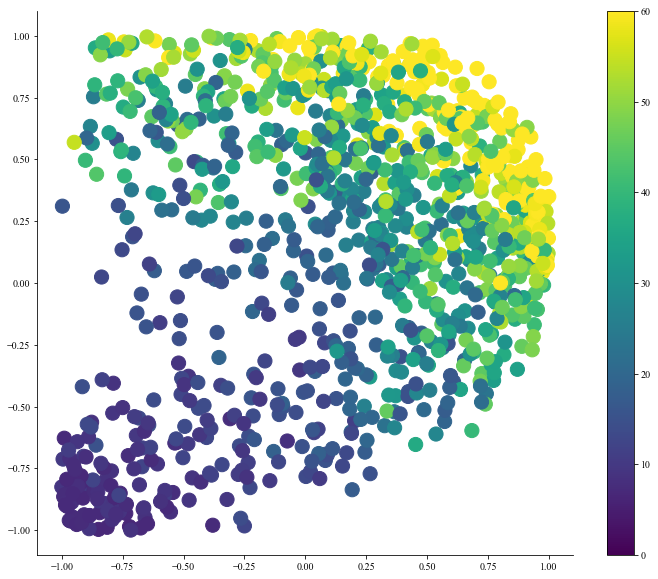

In [180]:
## Kinetic Maps with diffusion distances
phi_1 = distorted_eigfs[:,0]
phi_2 = distorted_eigfs[:,1]
fig, ax = plt.subplots(1,1,figsize=(12,10))

im = ax.scatter(phi_1[:],phi_2[:],s=200,c=phi_labels,vmax = 60,vmin=0.,alpha=1., cmap='viridis')
fig.colorbar(im)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.axis('off')
# 
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl6/phi1_phi2_heading.pdf')


In [143]:
speeds_head = speeds_head[:,:maxL,:]
speeds_head[phi_smooth.mask] = ma.masked

In [144]:
ps = 0.0071
K=7
meanKspeed_fish = [speeds_head[:,k:k+K,:].mean(axis=1).mean(axis=1) for k in range(len(speeds_head[0])-K)]
meanKspeed_fish = ma.vstack(meanKspeed_fish).T

meanKspeed = -1*ma.ones((speeds_head.shape[0],speeds_head.shape[1]))
meanKspeed[:,3:-4] = meanKspeed_fish
print(meanKspeed.shape)

meanKspeed[meanKspeed==-1] = ma.masked
meanKspeed_all = ma.hstack(meanKspeed)
speed_labels = np.asarray([ma.mean(meanKspeed_all[labels_all==kl]) for kl in range(1100)])*ps

(218, 946)


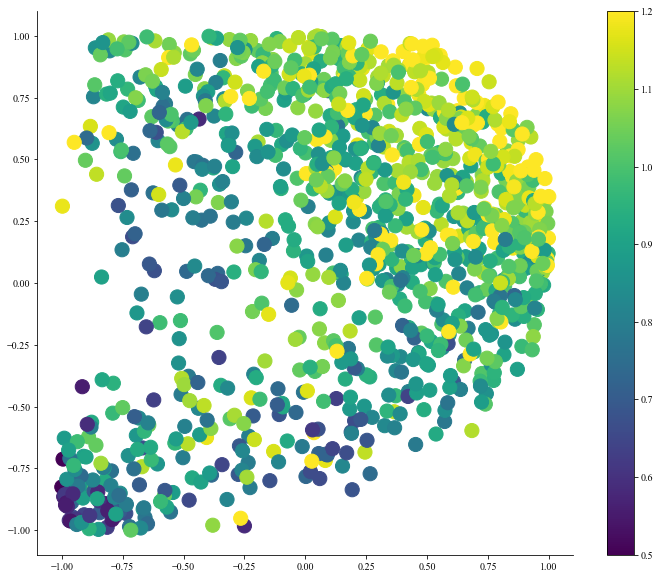

In [179]:
## Kinetic Maps with diffusion distances
fig, ax = plt.subplots(1,1,figsize=(12,10))

im = ax.scatter(phi_1[:],phi_2[:],s=200,c=speed_labels,vmax = 1.2,vmin=0.5,alpha=1., cmap='viridis')
fig.colorbar(im)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.axis('off')

# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/suppl6/phi1_phi2_speed.pdf')

In [146]:
phi_smooth[phi_smooth == 0] = ma.masked
phi_smooth = phi_smooth[:,:maxL,:]

In [154]:
print(phi_smooth.shape)

(218, 946, 40)


In [155]:
dphi_allcond = -100*ma.ones((phi_smooth.shape[0],phi_smooth.shape[1]))
for rec in range(218):
    print(rec)
    for b in range(lengths_all[rec]):
        phi_s,phi_e = phi_smooth[rec,b,0],phi_smooth[rec,b,:].compressed()[-1]
        dphi_allcond[rec,b] = (phi_e - phi_s)*(180/np.pi)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217


In [156]:
dphi_allcond[dphi_allcond==-100] = ma.masked
dphi_all = ma.hstack(dphi_allcond)
phis_embed = embed.trajectory_matrix(dphi_all[:,np.newaxis], K=4)
phis_avg = ma.mean(phis_embed,axis=1)

In [172]:
print(len(phis_avg.compressed()))
print(len(distorted_.compressed()))
print(dtrajs_fish_.shape)

112698
112541
(218, 946)


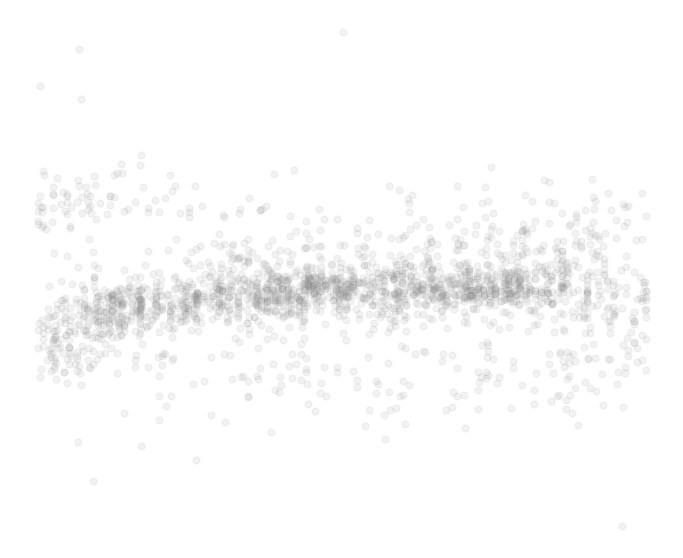

In [178]:
## Kinetic Maps with diffusion distances
fig, ax = plt.subplots(1,1,figsize=(12,10))

pmin = 0.0

distort_traj = ma.array(distorted_eigfs[:,2])[final_labels]
distort_traj[final_labels.mask] = ma.masked
dtrajs_fish_ = distort_traj.reshape(labels_fish.shape[0],labels_fish.shape[1])

distorted_ = ma.concatenate(dtrajs_fish_, axis=0)

# im = ax.scatter(distorted_[0::50],phis_avg[0::50],c='grey', alpha=0.1, s=50)
img = stats.density_plot(distorted_.compressed(),phis_avg.compressed()[:],[-1.1,1.1],[-80,80],90,90,smooth=True, border=3)


X,Y = np.meshgrid(np.linspace(-1.1,1.1,96), np.linspace(-80,80,96))
ax.contour(X,Y, img, cmap='magma', linewidths=4)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_ylim(-80,80)
ax.axis('off')

# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl6/phi3_var.png',dpi=300)

In [106]:
sort_clus_idx = np.argsort(coh_labels_phi1)[::-1]

(-0.5, 1099.5, 1099.5, -0.5)

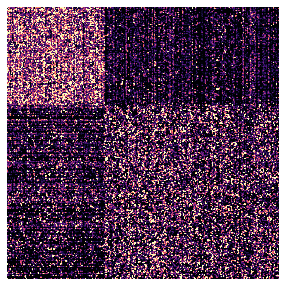

In [107]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
D2 = copy.deepcopy(P_ensemble.todense())
D2[:] = D2[sort_clus_idx,:]
D2[:] = D2[:,sort_clus_idx]

ax.imshow(D2, vmax = 0.003,cmap='magma')
ax.axis('off')
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl6/Tmat_WC.pdf')
# ax.colorbar()

In [113]:
st_names = ['Wandering','Cruising']
st_colors = ['#1F50A3','#D04D49']

In [114]:
kmeans_labels = coh_labels_phi1

In [115]:
cluster_traj_all = ma.copy(final_labels)
cluster_traj_all[~final_labels.mask] = ma.array(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj_all[final_labels.mask] = ma.masked

cluster_fish = cluster_traj_all.reshape(labels_fish.shape[0],labels_fish.shape[1])
cluster_fish_mask = cluster_fish.mask

In [111]:
cond_recs = np.arange(218)

maxL = np.max(lengths_all)

cluster_fish_condition = cluster_fish[cond_recs,:maxL]

cluster_traj = ma.concatenate(cluster_fish_condition, axis=0)
print(cluster_fish_condition.shape)

(95, 946)


In [112]:
print(cluster_traj.shape)
print(psi1.shape)

(89870,)
(89870,)


In [115]:
lifetimes_fish = [[],[],[],[],[],[],[],[]]
for cf in range(cluster_fish_condition.shape[0]):
    data_lifetimes, state_labels = stats.state_lifetime(cluster_fish_condition[cf],dt)
    for k,ks in enumerate(state_labels):
        if len(state_labels) == 1:
            print(len(lifetimes_fish[ks]),ks)
        lifetimes_fish[ks].append(data_lifetimes[k])

0 1
20 1
33 0
43 0
46 0
47 0
55 0
57 0
64 0
68 1
69 1
73 0
74 0
74 1


In [165]:
y_errorbar_metastate, x_all_metastate, m_all_metastate, b_all_metastate, tscales_metastate, params_metastate, mean_lifetimes = stats.state_lifetimes_stats(lifetimes_fish, n_states=2)

0


/Users/gautam.sridhar/Documents/Repos/ZebraBouts/utils/stats.py:476: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x,y = cumulative_dist(np.hstack(np.random.choice(lifetimes_fish[ks],len(lifetimes_fish[ks]))),(t0,tf))


1


0
1


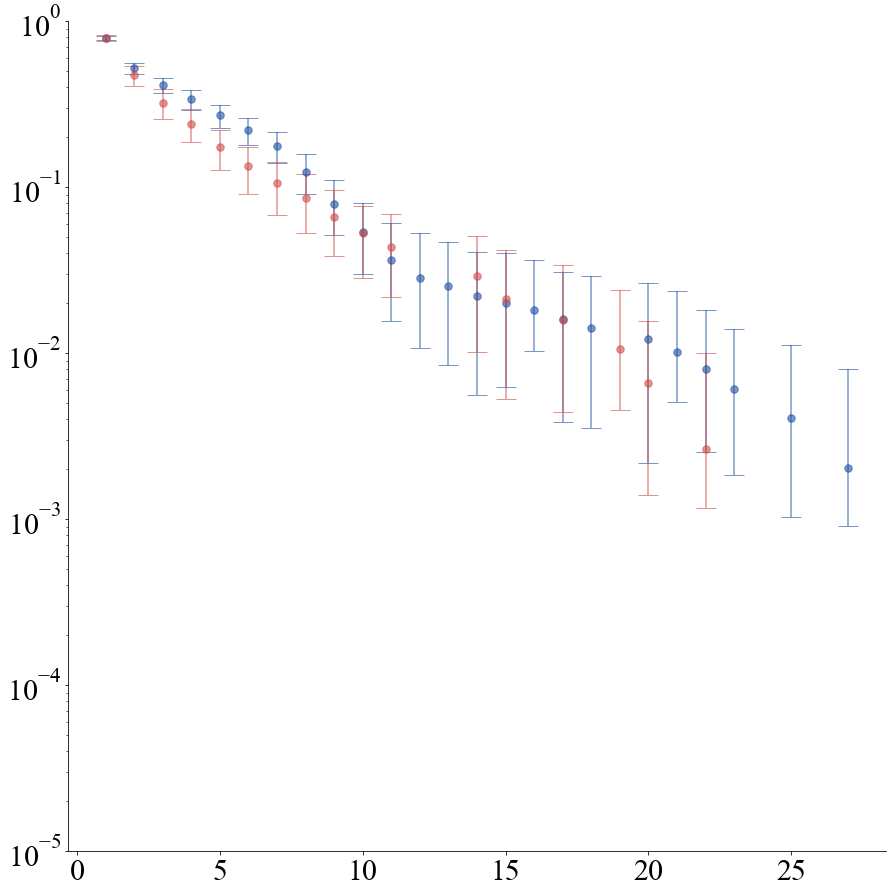

In [166]:
fig,ax = plt.subplots(1,1, figsize=(12.5,12.5))
t0,tf=1,600
xrange = np.linspace(t0,tf,160)
for ms in [0,1]:
    print(ms)

    mean = y_errorbar_metastate[ms][:-1,0]
    cil = y_errorbar_metastate[ms][:-1,1]
    ciu = y_errorbar_metastate[ms][:-1,2]
    
    params_cil = params_metastate[ms][0]
    params_ciu = params_metastate[ms][1]
    ax.errorbar(x_all_metastate[ms][:-1], mean,[mean-cil, ciu - mean],ms=15 ,fmt='.', capsize=10, color = st_colors[ms], alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yscale('log')

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
# ax.set_xlim(-1,200)
ax.set_ylim(1e-5,1)
plt.tight_layout()

# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl6/WC_dwelltime.pdf')

In [111]:
phi_smooth[phi_smooth == 0] = ma.masked
# phis = ma.concatenate(phi_smooth, axis=0)

In [124]:
print((phi_smooth*180/np.pi).max())

359.95444


In [119]:
phis_fish = [[],[],[],[],[],[],[],[]]
for cf in range(cluster_fish.shape[0]):
    for ks in np.unique(cluster_fish.compressed()):
        print(ks, cf)
        sel = cluster_fish[cf] == ks
        segments = np.where(np.abs(np.diff(np.concatenate([[False], sel, [False]]))))[0].reshape(-1, 2)
        if len(segments) == 0:
            continue
        sorted_indices = np.argsort(np.hstack(np.diff(segments,axis=1)))[::-1]
        avg_orientation = [] 
        for idx in sorted_indices:
            t0,tf = segments[idx]
            for j in range(t0,tf):
                angle = phi_smooth[cf,j]
                angle2 = angle[~angle.mask]
                orient_diff = np.abs((angle2[-1] - angle[0])*(180/np.pi))
                avg_orientation.append(orient_diff)
        phis_fish[ks].append(ma.hstack(avg_orientation))

0 0
1 0
0 1
1 1
0 2
1 2
0 3
1 3
0 4
1 4
0 5
1 5
0 6
1 6
0 7
1 7
0 8
1 8
0 9
1 9
0 10
1 10
0 11
1 11
0 12
1 12
0 13
1 13
0 14
1 14
0 15
1 15
0 16
1 16
0 17
1 17
0 18
1 18
0 19
1 19
0 20
1 20
0 21
1 21
0 22
1 22
0 23
1 23
0 24
1 24
0 25
1 25
0 26
1 26
0 27
1 27
0 28
1 28
0 29
1 29
0 30
1 30
0 31
1 31
0 32
1 32
0 33
1 33
0 34
1 34
0 35
1 35
0 36
1 36
0 37
1 37
0 38
1 38
0 39
1 39
0 40
1 40
0 41
1 41
0 42
1 42
0 43
1 43
0 44
1 44
0 45
1 45
0 46
1 46
0 47
1 47
0 48
1 48
0 49
1 49
0 50
1 50
0 51
1 51
0 52
1 52
0 53
1 53
0 54
1 54
0 55
1 55
0 56
1 56
0 57
1 57
0 58
1 58
0 59
1 59
0 60
1 60
0 61
1 61
0 62
1 62
0 63
1 63
0 64
1 64
0 65
1 65
0 66
1 66
0 67
1 67
0 68
1 68
0 69
1 69
0 70
1 70
0 71
1 71
0 72
1 72
0 73
1 73
0 74
1 74
0 75
1 75
0 76
1 76
0 77
1 77
0 78
1 78
0 79
1 79
0 80
1 80
0 81
1 81
0 82
1 82
0 83
1 83
0 84
1 84
0 85
1 85
0 86
1 86
0 87
1 87
0 88
1 88
0 89
1 89
0 90
1 90
0 91
1 91
0 92
1 92
0 93
1 93
0 94
1 94
0 95
1 95
0 96
1 96
0 97
1 97
0 98
1 98
0 99
1 99
0 100
1 100
0 101
1 

In [120]:
y_ebs_phis, x_all_phis = stats.dist_bootstrap(phis_fish, 0, 140, 2, 10)

/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/stats.py:115: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x,y = cumulative_dist(np.hstack(np.random.choice(statscollection_fish[ms],len(statscollection_fish[ms]))),(t0,tf))


(0.0001, 1.0)

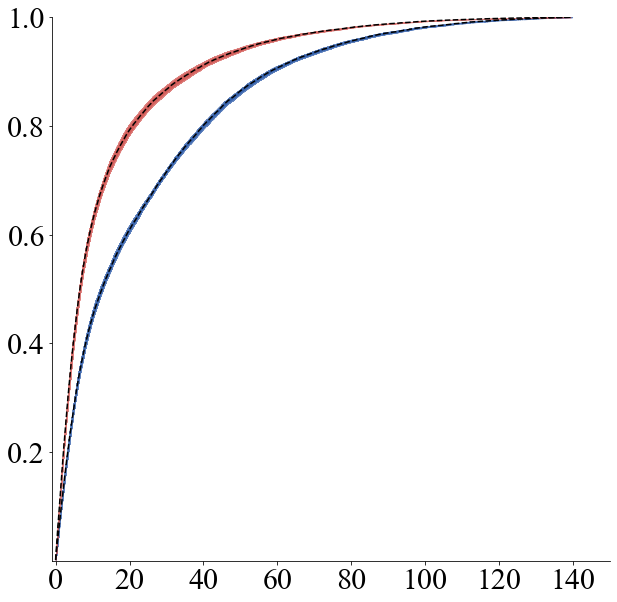

In [121]:
fig,ax = plt.subplots(1,1, figsize=(10,10))

for ms in np.unique(cluster_traj_all.compressed()):
    mean = y_ebs_phis[ms][:-1,0]
    cil = y_ebs_phis[ms][:-1,1]
    ciu = y_ebs_phis[ms][:-1,2]
    ax.plot(x_all_phis[ms], 1-y_ebs_phis[ms][:,0], color='k', ls = '--', alpha=1.)
    ax.fill_between(x_all_phis[ms], 1-y_ebs_phis[ms][:,1], 1-y_ebs_phis[ms][:,2], alpha=0.7, color=st_colors[ms])
#     ax.errorbar(x_all_phis[ms][:-1], mean,[mean-cil, ciu - mean], fmt='.', capsize=10, color = st_colors[ms], alpha=0.2)
        
# ax.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_yscale('log')
# ax.set_xlabel(r'$\Delta$ Orientation per bout ($\circ$)',fontsize=35)
# ax.set_ylabel('CDF',fontsize= 40)
# ax.legend(loc="upper left",bbox_to_anchor=(1.0, 1.05), fontsize=40, ncol=2)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.set_xlim(-1,150)
ax.set_ylim(1e-4,1)

# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl6/WC_heading.pdf')
# plt.show()/

In [211]:
cond = 0
cond_recs = np.where(ph_idx == cond)[0]

all_headX_cond = ma.concatenate(X_head[cond_recs,:],axis=0)
all_headX_cond[all_headX_cond==0] = ma.masked

all_head_start = all_headX_cond[:,0,1]
nonph_idx = np.where(np.logical_and(all_head_start<1500, all_head_start>500))[0]

In [214]:
500*ps

3.5500000000000003

In [212]:
print(all_head_start.shape)

(116358,)


<ipython-input-213-56d200c82d3f>:22: UserWarning: linewidths is ignored by contourf
  im = ax.contourf(X,Y, img, cmap='Greys', linewidths=2, levels = 17)


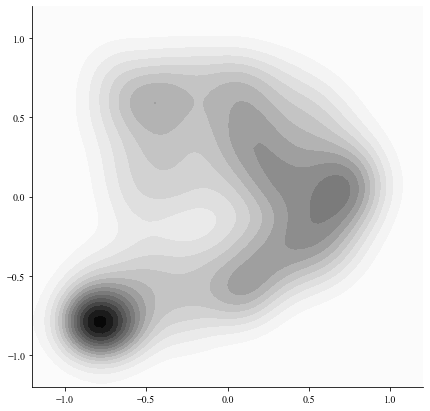

In [213]:
fig, ax  = plt.subplots(1,1,figsize=(7, 7))

xrange=[-1.2, +1.2]
yrange=[-1.2, +1.2]

all_head_start

psi1 = ma.concatenate(dtrajs_fish_phi1[cond_recs,:], axis=0)
psi2 = ma.concatenate(dtrajs_fish_phi2[cond_recs,:], axis=0)

psi1[nonph_idx] = ma.masked # Mask nonph 
psi2[nonph_idx] = ma.masked

img= stats.density_plot(psi1.compressed(), psi2.compressed(), xrange, yrange, 60,60,smooth=True, border=4)

X,Y = np.meshgrid(np.linspace(-1.2,1.2,68), np.linspace(-1.2,1.2,68))
im = ax.contourf(X,Y, img, cmap='Greys', linewidths=2, levels = 17)
# fig.colorbar(im)


# im = ax.imshow(img, cmap='inferno', origin='lower')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl6/ph_mes.pdf')